# FINAL YEAR PROJECT

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import collections
from collections import Counter,OrderedDict
from scipy import stats

Instructions for updating:
non-resource variables are not supported in the long term


## Data Preparation

In [3]:
column_names = ["UserID"]
users = pd.read_csv("users.csv", header=None, names=column_names, engine="python")
users["ContinuousUserID"] = users.index

In [4]:
column_names = ["MovieID", "Title", "Genres"]
movies_df = pd.read_csv("movies.csv", header=None, names=column_names, engine="python")
movies_df = movies_df.drop([0],axis=0).reset_index()
movies_df = movies_df.drop(["index"], axis=1)
print("Movie Rows:", len(movies_df))
movies_df.MovieID = movies_df.MovieID.astype(int)
movies_df.info()

Movie Rows: 9742
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  9742 non-null   int32 
 1   Title    9742 non-null   object
 2   Genres   9742 non-null   object
dtypes: int32(1), object(2)
memory usage: 190.4+ KB


In [5]:
column_names = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv("ratings.csv", header=None, names=column_names)
ratings_df = ratings_df.drop([0],axis=0).reset_index()
ratings_df = ratings_df.drop(["index"], axis=1)
print("Ratings Rows:", len(ratings_df))
ratings_df['UserID'] = ratings_df['UserID'].astype(int)
ratings_df['MovieID'] = ratings_df['MovieID'].astype(int)
ratings_df['Timestamp'] = ratings_df['Timestamp'].astype(int)
ratings_df['Rating'] = pd.to_numeric(ratings_df.Rating.str.replace('.0','')).astype(int)
ratings_df['Count'] = ratings_df['MovieID'].map(ratings_df['MovieID'].value_counts())
ratings_df = ratings_df[ratings_df['Count'] >= 20]
ratings_df.sort_values(['MovieID'], ascending=False)

Ratings Rows: 100836


,UserID,MovieID,Rating,Timestamp,Count
100834,610,168252,5,1493846352,25
11618,68,168252,4,1526947535,25
2267,18,168252,4,1493155981,25
95067,599,168252,3,1498529615,25
3660,21,168252,3,1500701559,25
...,...,...,...,...,...
80373,509,1,4,1435992343,215
1772,18,1,3,1455209816,215
25881,179,1,4,852114051,215
25804,178,1,4,1164354911,215


In [6]:
ratings_df.Count.sum()
#ini ada overlap karena setiap filmnya dirating, Countnya juga keitung

5649628

In [7]:
movies_df = pd.merge(movies_df,ratings_df[['MovieID','Count']],on='MovieID', how='left')
movies_df = movies_df.fillna(0)
movies_df = movies_df[movies_df['Count'] != 0.0]
movies_df = movies_df.drop_duplicates(subset='MovieID', keep="first").reset_index()
movies_df['List Index'] = movies_df.index.astype(int)
movies_df = movies_df.drop('index',axis=1)
movies_df.head()

,MovieID,Title,Genres,Count,List Index
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,110.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,52.0,2
3,5,Father of the Bride Part II (1995),Comedy,49.0,3
4,6,Heat (1995),Action|Crime|Thriller,102.0,4


In [8]:
#Merge movies_df with ratings_df by MovieID
merged_df = movies_df.merge(ratings_df, on='MovieID')

# Drop unnecessary columns
merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1).drop('Count_y',axis=1).drop('Count_x',axis=1)

# Display the result
merged_df.MovieID = merged_df.MovieID.astype(int)
merged_df.shape

(67898, 4)

Total penilaian ada 67898 terhadap film yang sudah diseleksi

In [9]:
# Lets Group up the Users by their user ID's
user_Group = merged_df.groupby('UserID')

## Machine Learning Infrastructure
### Restricted Bolztmann Machines

In [10]:
# Amount of users used for training
amountOfUsedUsers = 610

# Creating the training list
trX = []

# For each user in the group
for userID, curUser in user_Group:

    # Create a temp that stores every movie's rating
    temp = [0]*len(movies_df)

    # For each movie in curUser's movie list
    for num, movie in curUser.iterrows():

        # Divide the rating by 5 and store it
        temp[movie['List Index']] = movie['Rating']/5.0

    # Add the list of ratings into the training list
    trX.append(temp)

    # Check to see if we finished adding in the amount of users for training
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1
print(len(trX))

610


In [11]:
# Setting the models Parameters
hiddenUnits = 30
visibleUnits = len(movies_df)
vb = tf.placeholder(tf.float32, [visibleUnits])  # Number of unique movies
hb = tf.placeholder(tf.float32, [hiddenUnits])  # Number of features were going to learn
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])  # Weight Matrix
# Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits]) #bisa memiliki jumlah baris sebanyak apapun dengan kolom fix berjumlah sebanyak film
h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  # Visible layer activation, langkah pertama untuk menghitung CD positive

_hs = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
hs = tf.nn.relu(tf.sign(_hs - tf.random_uniform(tf.shape(_hs),maxval=1)))  # Gibb's Sampling

# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(hs, tf.transpose(W)) + vb)  # Hidden layer activation
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1),maxval=1))) #sign menghasilkan -1 bila input negatif dan 1 bila positif, kemudian -1 diubah menjadi 0 dengan fungsi relu
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [12]:
# Learning rate
alpha = 0.2

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

Instructions for updating:
Use `tf.cast` instead.


In [13]:
""" Initialize our Variables with Zeroes using Numpy Library """

# Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)

# Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)

# Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)

# Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Training Process

11.404088139533997
9.947159141302109
9.397996962070465
9.118158370256424
9.03506651520729
8.895601332187653
8.837510645389557
8.806366473436356
8.781491965055466
8.639625459909439
8.431731164455414
8.393104374408722
8.36019292473793
8.32148939371109
8.363023400306702
8.37179496884346
8.366688340902328
8.310088515281677
8.350712060928345
8.371593058109283
8.37935358285904
8.32207053899765
8.423642069101334
8.361455798149109
8.332131803035736
8.397528529167175
8.421316742897034
8.388176560401917
8.366537094116211
8.463405817747116


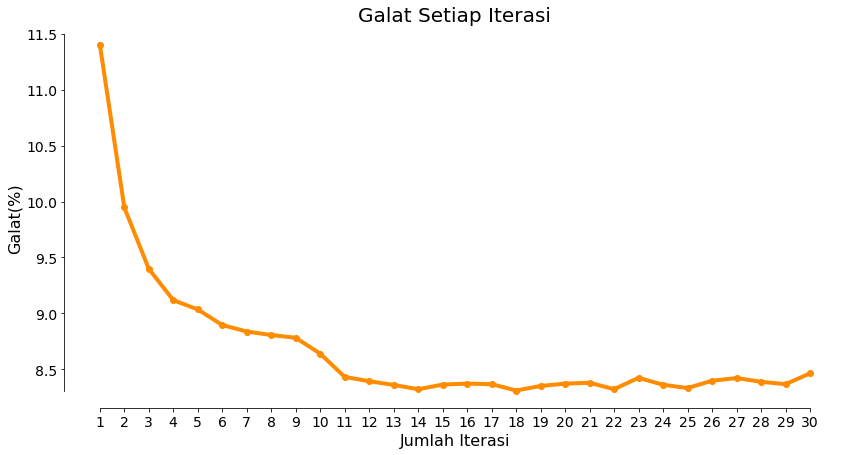

In [14]:
from matplotlib.ticker import MaxNLocator
# Train RBM with 15 Epochs, with Each Epoch using 10 batches with size 100, After training print out the error by epoch
epochs = 30
batchsize = 10
errors = []
iterasi =['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30']
for i in range(epochs):
    for start, end in zip(range(0, len(trX)+batchsize, batchsize), range(batchsize, len(trX)+batchsize, batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb})*100)
    print(errors[-1])
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# ax.set_xticks(iterasi)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(iterasi, errors, marker='o', color='darkorange', linewidth=4)
plt.ylabel('Galat(%)', fontsize=16)
plt.xlabel('Jumlah Iterasi', fontsize=16)
plt.title('Galat Setiap Iterasi', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Error.png')
plt.show()

## Result From One User

In [15]:
# Select the input User
inputUser = [trX[0]]

# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

# List the 20 most recommended movies for our mock user by sorting it by their scores given by our model.
scored_movies_df_50 = movies_df
scored_movies_df_50["Recommendation Score"] = rec[0]
scored_movies_df_50.sort_values(["Recommendation Score"], ascending=False).head(10).drop('List Index', axis=1).drop('Genres', axis=1)


,MovieID,Title,Count,Recommendation Score
614,2571,"Matrix, The (1999)",278.0,0.654752
120,356,Forrest Gump (1994),329.0,0.650219
84,260,Star Wars: Episode IV - A New Hope (1977),251.0,0.636452
97,296,Pulp Fiction (1994),307.0,0.598688
306,1196,Star Wars: Episode V - The Empire Strikes Back...,211.0,0.598687
105,318,"Shawshank Redemption, The (1994)",317.0,0.574442
184,593,"Silence of the Lambs, The (1991)",279.0,0.559713
674,2959,Fight Club (1999),218.0,0.519988
308,1198,Raiders of the Lost Ark (Indiana Jones and the...,200.0,0.499999
39,110,Braveheart (1995),237.0,0.490002


In [16]:
##### """ Recommend User what movies he has not watched yet """


# Find all movies the mock user has watched before
movies_df_50 = merged_df[merged_df['UserID'] == merged_df.iloc[0]['UserID']]
movies_df_50.sort_values(['Rating'], ascending=False)

,MovieID,List Index,UserID,Rating
50088,5060,885,1,5
23339,1240,334,1,5
27477,1517,417,1,5
38752,2761,648,1,5
39415,2858,660,1,5
...,...,...,...,...
28899,1644,441,1,3
37245,2617,623,1,2
22587,1219,322,1,2
34187,2253,554,1,2


In [17]:
""" Merge all movies that our mock users has watched with predicted scores based on his historical data: """

# Merging movies_df with ratings_df by MovieID
merged_df_50 = scored_movies_df_50.merge(movies_df_50, on='MovieID', how='outer')

# Dropping unnecessary columns
merged_df_50 = merged_df_50.drop('List Index_y', axis=1).drop('UserID', axis=1).drop('List Index_x', axis=1)




""" There are some movies the user has not watched and has high score based on our model. So, we can recommend them. """
# Sort and take a look at first 20 rows

merged_df_50.sort_values(['Recommendation Score'], ascending=False).head(10).drop('Genres',axis=1).rename(columns={'Title': 'Nama Film',                                                                                                               'Recommendation Score': 'Skor Rekomendasi'
,'Rating': 'Nilai'})

,MovieID,Nama Film,Count,Skor Rekomendasi,Nilai
614,2571,"Matrix, The (1999)",278.0,0.654752,5.0
120,356,Forrest Gump (1994),329.0,0.650219,4.0
84,260,Star Wars: Episode IV - A New Hope (1977),251.0,0.636452,5.0
97,296,Pulp Fiction (1994),307.0,0.598688,3.0
306,1196,Star Wars: Episode V - The Empire Strikes Back...,211.0,0.598687,5.0
105,318,"Shawshank Redemption, The (1994)",317.0,0.574442,NaN
184,593,"Silence of the Lambs, The (1991)",279.0,0.559713,4.0
674,2959,Fight Club (1999),218.0,0.519988,5.0
308,1198,Raiders of the Lost Ark (Indiana Jones and the...,200.0,0.499999,5.0
39,110,Braveheart (1995),237.0,0.490002,4.0


## Longtail and Shorthead Separation

In [18]:
movie_sort_popularity = movies_df.sort_values(['Count'], ascending=False).reset_index().drop(['index'],axis=1)
movie_sort_popularity[:50]
movie_sort_popularity.to_csv (r'C:\Users\Reyhan\Dev\Kodingan Tugas Akhir 1\Fix\movies_df.csv', index = False, header=True)

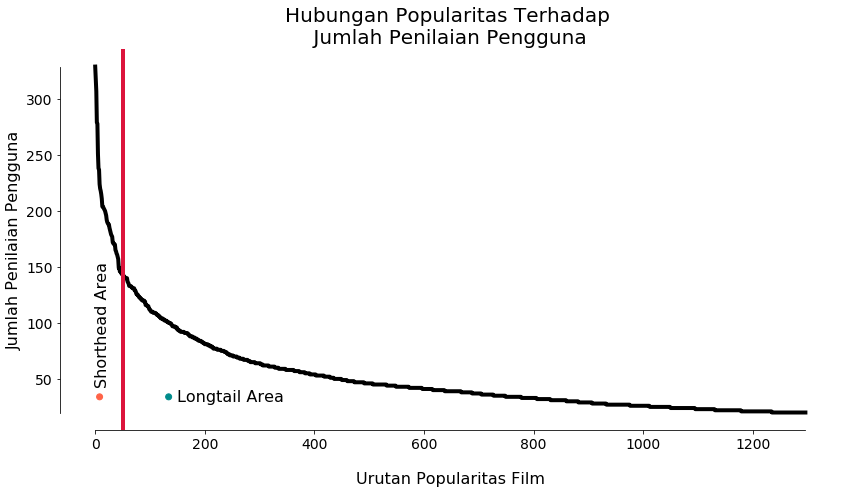

In [19]:
#plot popularitas
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.text(150,30, "Longtail Area", fontsize=16,)
ax.text(0, 45, "Shorthead Area", fontsize=16, rotation=90)
ax.scatter([8, 134], [34,34], color=['tomato', 'darkcyan'])
ax.set_xlabel('Urutan Popularitas Film', fontsize=16,labelpad=20)

plt.plot(movie_sort_popularity.Count, color='black', linewidth=4)
plt.ylabel('Jumlah Penilaian Pengguna', fontsize=16)
#plt.xlabel('Urutan Popularitas Film', fontsize=16)
plt.title('Hubungan Popularitas Terhadap \n Jumlah Penilaian Pengguna ', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x= 50, color = 'crimson', linewidth=4)
plt.savefig('Popularity_bias.png')
plt.show()

Kita pilih urutan popularitas film 50 sebagai batas antara shorthead dan longtail.

In [20]:
movie_sort_popularity.Count[:50].sum()

9807.0

Dari 1297 film, 50 film teratas mendapatkan rating sebanyak 9807 kali

In [21]:
movie_sort_popularity.Count.sum()*0.145

9845.21

Jika kita urutkan, 14,5% jumlah rating menempati 50 film teratas yang porsinya hanya 3,85% dari seluruh film.

In [22]:
short = movie_sort_popularity[:50]
short_id = short.MovieID.tolist() #batasnya 143 count

In [23]:
long = movie_sort_popularity[50:]
long_id = long.MovieID.tolist()

In [24]:
top_10_container=[]
top_10_container_id = []
for x in range(0,610):
    inputUser = [trX[x]]

    # Feeding in the User and Reconstructing the input
    hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
    feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
    rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

     # List the 20 most recommended movies for our mock user by sorting it by their scores given by our model.
    result = movies_df.copy()
    result["Recommendation Score"] = rec[0]
    result_10 = result.sort_values(["Recommendation Score"], ascending=False).head(10)
    top_10_tittle = result_10['Title']
    for i in top_10_tittle:
         top_10_container.append(i)
    top_10_id = result_10['MovieID']
    for i in top_10_id:
         top_10_container_id.append(i)


In [25]:
counter_top_10 = Counter(top_10_container)
counter_top_10_id = Counter(top_10_container_id) 

In [26]:
sorted_top_10_id = sorted(counter_top_10_id.items(), key=lambda kv: kv[1], reverse=True)
ordered_top_10_id = collections.OrderedDict(sorted_top_10_id)

sorted_top_10 = sorted(counter_top_10.items(), key=lambda kv: kv[1], reverse=True)
ordered_top_10 = collections.OrderedDict(sorted_top_10)

In [27]:
df1 = pd.DataFrame(ordered_top_10.items(), columns=['Name', 'Count'])


In [28]:
df2 = pd.DataFrame(ordered_top_10_id.items(), columns=['ID', 'Count'])

In [29]:
df1["ID"] = df2["ID"]

In [30]:
print(df1.head())
print(len(df1))

Name  Count   ID
0           Shawshank Redemption, The (1994)    610  318
1                        Pulp Fiction (1994)    518  296
2                        Forrest Gump (1994)    477  356
3                          Braveheart (1995)    459  110
4  Star Wars: Episode IV - A New Hope (1977)    441  260
31


In [31]:
df1["Count"].sum()

6100

In [32]:
custom_palette = {}
for q in df1["ID"]:
    if q in short_id:
        custom_palette[q] = 'tomato'
    else:
        custom_palette[q] = 'darkcyan'

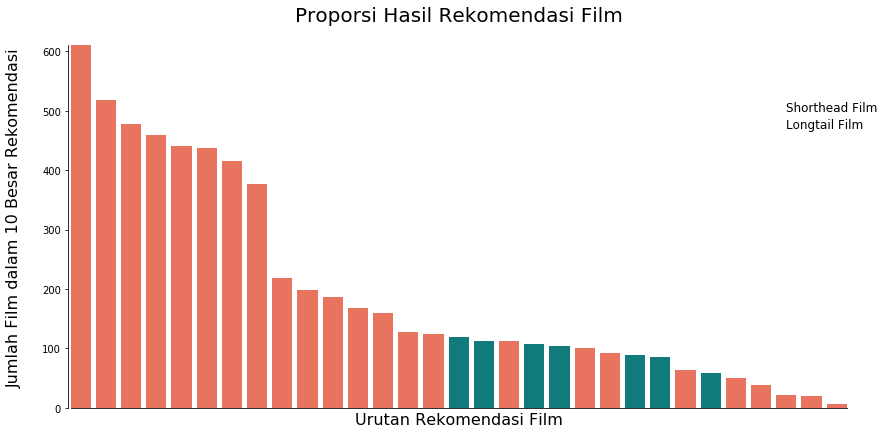

In [33]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Jumlah Rekomendasi Ke Pengguna', fontsize=16,labelpad=20)
ax.text(28,470, "Longtail Film", fontsize=12,)
ax.text(28, 500, "Shorthead Film", fontsize=12)
#ax.scatter([20, 500], [20,450], color=['lightcoral', 'grey'])
# plt.xticks(rotation=90, fontsize=12) 
sns.barplot(x="ID", y="Count", data=df1, palette=custom_palette, order=df1['ID'])
plt.xlabel('Urutan Rekomendasi Film', fontsize=16)
plt.title('Proporsi Hasil Rekomendasi Film', fontsize=20)
plt.ylabel('Jumlah Film dalam 10 Besar Rekomendasi', fontsize=16)
    

plt.savefig('Recommendation_Top10_Before.png')


In [34]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

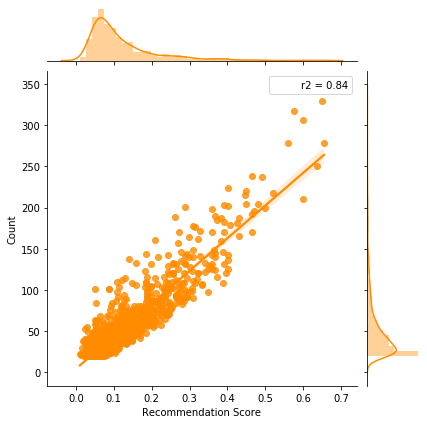

In [35]:
sns.jointplot(x='Recommendation Score', y='Count', data=movie_sort_popularity, color='darkorange', kind="reg",stat_func=r2);

In [36]:
sum_short = 0
for i in df1["ID"]:
    if i in short_id:
        sum_short = sum_short + int(df1[df1["ID"] == i]["Count"])

print(sum_short/6010)

0.9021630615640599


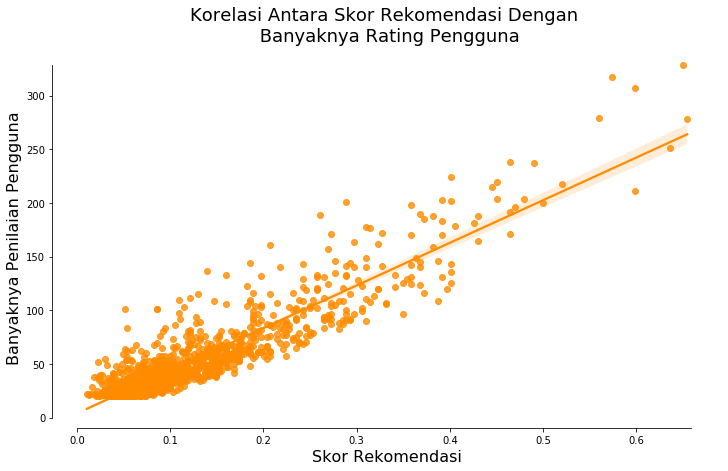

In [66]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
plt.title('Korelasi Antara Skor Rekomendasi Dengan \n Banyaknya Rating Pengguna', fontsize=18)
ax.set(xlabel='Skor Rekomendasi', ylabel='Banyaknya Rating Pengguna')
sns.regplot(x='Recommendation Score', y='Count', data=movie_sort_popularity, color='darkorange')
plt.xlabel('Skor Rekomendasi', fontsize=16)
plt.ylabel('Banyaknya Penilaian Pengguna', fontsize=16)
plt.savefig('Korelasi')



In [67]:
def randomly(seq):
    shuffled = list(seq)
    random.shuffle(shuffled)
    return iter(shuffled)

In [68]:
print(len(trX))

610


In [200]:
longtail_w = 0.8
s_container = []
sb_container = []
movieid_container =[]
ratio_container=[]
for x in range(0,610): #programmnya berat, semua range sampe 609
    inputUser = [trX[x]] #harusnya trx x
    print(x)
    # Feeding in the User and Reconstructing the input
    hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
    feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
    rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})
    
    #find out ratio of User iloc x, it is working
    user_history = merged_df[merged_df['UserID'] == merged_df.iloc[x]['UserID']]['MovieID'].tolist() #movie ID yang telah ditonton
    count=0
    for i in user_history:
        if i in short_id:
            count+=1
    short_ratio = count/len(user_history)
    ratio_container.append(short_ratio)
    result = movies_df.copy()
    result["Recommendation Score"] = rec[0] #rec[0] merupakan nilai rekomendasi untuk semua film terhadap user x
    result_100 = result.sort_values(["Recommendation Score"], ascending=False).head(100)
    rec = result_100['MovieID'].tolist()
    result_10 = result.sort_values(["Recommendation Score"], ascending=False).head(10)
    rec_10 = result_10['MovieID'].tolist()
    # Find a new score
    count_s_b=0
    count_l_b=0
    for x in rec_10:
        if x in short_id:
            count_s_b +=1
        else:
            count_l_b +=1
    sb_container.append(count_s_b)
    #sampe sini saya paham        
    R = [rec[0]] #butuh ini untuk evaluasi no 1
    rec.remove(rec[0]) #kita buang urutan pertama dari 100 besar
    for k in range(0,9): #karena yang pertama sudah dapet, kita tinggal hitung 9 sisanya
        temporary=[]
        for i in rec: #evaluasi untuk 99 besar lainnya    
            count_s_count = 0 #kayaknya salah disini
            count_l_count = 0
            for s in R: # evaluasinya di awal jadinya untuk append terakhir tidak terevealuasi
                if s in short_id:
                    count_s_count +=1
                else:
                    count_l_count +=1

            f = result[result.MovieID == i]
            wbs = (1-longtail_w)*f['Recommendation Score'].values
            if i in short_id:             
                wcb = longtail_w *short_ratio*(1-(count_s_count/len(R)))**len(R)
            else:
                wcb = longtail_w *(1-short_ratio)*(1-(count_l_count/len(R)))**len(R)    
            new_score = wbs+wcb
            temporary.append(new_score)
            
        #find max temporary
        indeks = temporary.index(max(temporary))
        R.append(rec[indeks])
        count_s = 0 #kayaknya salah disini
        count_l = 0
        for s in R: # evaluasinya di awal jadinya untuk append terakhir tidak terevealuasi
                if s in short_id:
                    count_s +=1
                else:
                    count_l +=1
        rec.remove(rec[indeks])
    s_container.append(count_s)
    for movieid in R:
        movieid_container.append(str(movieid))
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [201]:
rec_10

[2571, 356, 260, 296, 1196, 318, 593, 2959, 1198, 110]

In [202]:
R

[2571, 1136, 1265, 356, 260, 1200, 296, 1196, 318, 593]

In [203]:
df = pd.DataFrame(list(zip(sb_container, s_container)), 
               columns =['Before', 'After']) 

In [204]:
df["Before"].value_counts()

10    377
6      85
7      78
9      36
8      34
Name: Before, dtype: int64

In [205]:
df["After"].value_counts()

7    405
6    181
5     24
Name: After, dtype: int64

In [206]:
dfx = pd.DataFrame({"Before":[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                    "After":[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}) 

In [207]:
df = df.append(dfx)


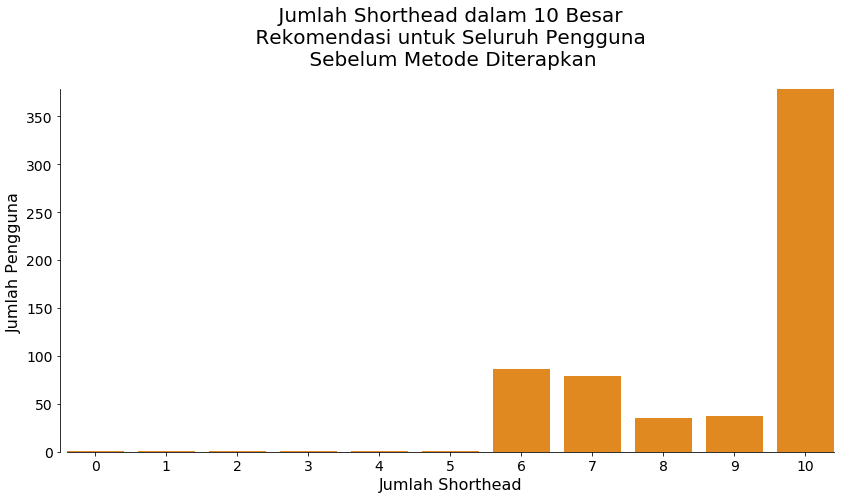

In [208]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# ax.text(150,30, "Longtail Area", fontsize=16,)
# ax.text(0, 45, "Shorthead Area", fontsize=16, rotation=90)
# ax.scatter([8, 134], [34,34], color=['lightcoral', 'grey'])
# ax.set_xlabel('Urutan Popularitas Film', fontsize=16,labelpad=20)

# plt.plot(movie_sort_popularity.Count, color='grey', linewidth=4)
plt.ylabel('Jumlah Penilaian Pengguna', fontsize=16)
#plt.xlabel('Urutan Popularitas Film', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.countplot(x='Before', data=df, color='darkorange')
plt.title(' Jumlah Shorthead dalam 10 Besar \n Rekomendasi untuk Seluruh Pengguna \n Sebelum Metode Diterapkan', fontsize=20)
plt.xlabel('Jumlah Shorthead', fontsize=16)
plt.ylabel('Jumlah Pengguna', fontsize=16)

# plt.savefig('Shorthead_before.png')
plt.show()

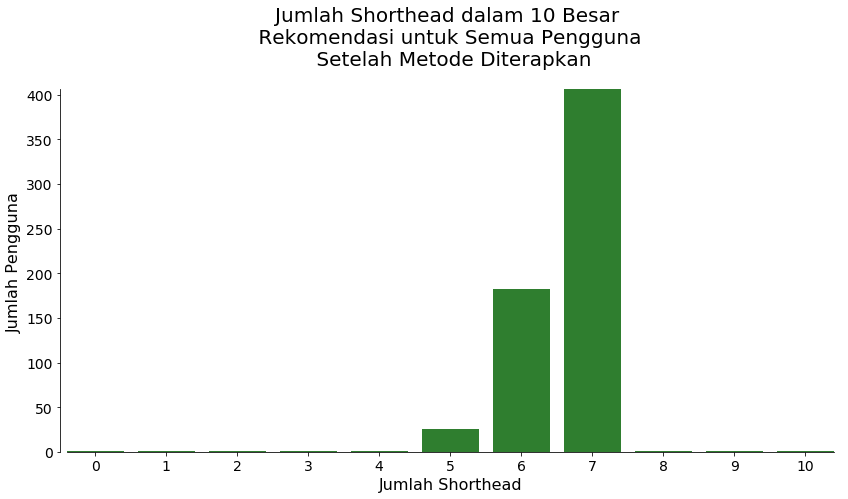

In [209]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.title('Hubungan Popularitas Terhadap \n Jumlah Penilaian Pengguna ', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.countplot(x='After', data=df, color="forestgreen")
plt.title('Jumlah Shorthead dalam 10 Besar \n Rekomendasi untuk Semua Pengguna \n Setelah Metode Diterapkan', fontsize=20)
plt.xlabel('Jumlah Shorthead', fontsize=16)
plt.ylabel('Jumlah Pengguna', fontsize=16)

plt.savefig('Shorthead_after.png')

In [210]:
df2 = pd.DataFrame(movieid_container,columns=["Id"])

In [211]:
df2 = df2['Id'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [212]:
df2.head()

,unique_values,counts
0,318,610
1,296,509
2,356,475
3,593,418
4,2571,366


In [213]:
df2.unique_values.astype('int')

0        318
1        296
2        356
3        593
4       2571
5        260
6       1200
7       1196
8         39
9       1265
10      1136
11     79132
12      2959
13      7361
14       253
15        50
16       733
17       150
18       457
19       110
20       293
21       454
22         1
23       339
24      7153
25    116797
26       592
27      4993
28      2329
29       589
30     48516
31      5952
32        10
33     60069
34      1197
35        34
36      1704
37       597
38      1221
39      1291
40      6377
41      2716
42       480
Name: unique_values, dtype: int32

In [214]:
df2.head()

,unique_values,counts
0,318,610
1,296,509
2,356,475
3,593,418
4,2571,366


In [215]:
custom_palette = {}
for q in df2["unique_values"]:
    if int(q) in short_id:
        custom_palette[q] = 'tomato'
    else:
        custom_palette[q] = 'darkcyan'

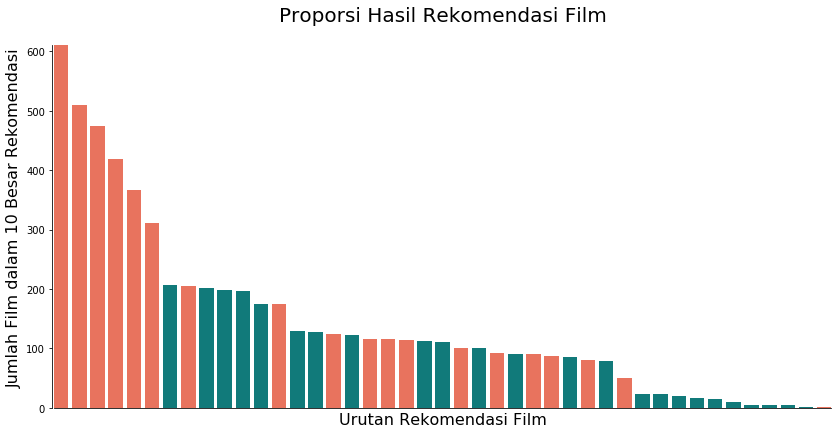

In [216]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.yaxis.set_ticks_position('left')
sns.barplot(x="unique_values", y="counts", data=df2, palette=custom_palette, order=df2['unique_values'])
plt.xlabel('Urutan Rekomendasi Film', fontsize=16)
plt.title('Proporsi Hasil Rekomendasi Film', fontsize=20)
plt.ylabel('Jumlah Film dalam 10 Besar Rekomendasi', fontsize=16)
plt.savefig('Recommendation_Top10_after.png')

In [217]:
sum_short = 0
for i in df2["unique_values"]:
    if int(i) in short_id:
        sum_short = sum_short + int(df2[df2["unique_values"] == i]["counts"])

print(sum_short/6010)

0.6723793677204659


In [218]:
round_to_hundreds = [round(num, 8) for num in ratio_container]

## Pembuktian Metode

In [219]:
result_df = pd.DataFrame(list(zip(sb_container, s_container)), 
               columns =['before', 'after']) 

In [220]:
result_df["ratio_bf"] = (result_df["before"]-result_df["after"])/result_df["before"] 

In [221]:
result_df["ratio_real"] = round_to_hundreds

In [222]:
result_df.head(10)

,before,after,ratio_bf,ratio_real
0,10,7,0.300000,0.160221
1,10,7,0.300000,0.439024
2,10,7,0.300000,0.209677
3,10,7,0.300000,0.229508
4,6,6,0.000000,0.326531
5,6,5,0.166667,0.126344
6,10,7,0.300000,0.072139
7,6,6,0.000000,0.113014
8,10,7,0.300000,0.148515
9,7,6,0.142857,0.279070


In [223]:
result_df.to_csv (r'C:\Users\Reyhan\Dev\Kodingan Tugas Akhir 1\Fix\result_1.csv', index = False, header=True)

In [224]:
df2.to_csv (r'C:\Users\Reyhan\Dev\Kodingan Tugas Akhir 1\Fix\movieid_1.csv', index = False, header=True)